In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
import numpy as np
import joblib

# Check if MPS is available and set the device accordingly
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f'Using device: {device}')

df = pd.read_csv('result.csv')

df


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/lihaoq/opt/anaconda3/envs/ggbaker/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/lihaoq/opt/anaconda3/envs/ggbaker/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/lihaoq/opt/anaconda3/envs/ggbaker/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739,

Using device: mps


,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,popularity,speechiness,tempo,valence,popularity_level
0,0.84800,0.400,165360,0.205,0.000000,7,0.4000,-11.794,1.0,0.0270,79.545,0.357,0
1,0.56000,0.686,127027,0.844,0.000001,10,0.1200,-6.163,2.0,0.0484,109.039,0.897,0
2,0.57100,0.467,148533,0.277,0.001160,9,0.0762,-13.049,5.0,0.0302,86.895,0.597,0
3,0.78900,0.522,134520,0.673,0.000000,11,0.3180,-3.480,5.0,0.0425,141.010,0.659,0
4,0.60800,0.635,145013,0.829,0.000000,9,0.1860,-5.125,6.0,0.0471,139.426,0.963,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9511,0.02640,0.611,132303,0.688,0.000000,1,0.2510,-5.688,94.0,0.3410,178.462,0.393,2
9512,0.69200,0.824,209438,0.588,0.000104,6,0.1490,-6.400,94.0,0.0924,98.027,0.513,2
9513,0.32100,0.834,247059,0.454,0.000006,1,0.1140,-9.750,95.0,0.2010,81.618,0.837,2
9514,0.10400,0.896,196653,0.586,0.000000,10,0.7900,-6.687,95.0,0.0559,116.971,0.642,2


In [2]:
# Define features and target
features = ["loudness", "energy", "speechiness", "danceability", "tempo", "key", "liveness", "instrumentalness", "valence", "acousticness", "duration_ms"]
target = "popularity_level"

# Split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('minmax', MinMaxScaler(), [
        'tempo', 'duration_ms', 'loudness', 
        'energy', 'speechiness', 'danceability', 'liveness', 
        'instrumentalness', 'valence',  
        'acousticness'
    ]),
    ('categorical', OneHotEncoder(), ['key'])
], remainder='passthrough')

# Creating a pipeline with make_pipeline
pipeline = make_pipeline(preprocessor)

# Fit and transform the data using the pipeline
X_train_transformed = pipeline.fit_transform(X_train, y_train)
X_test_transformed = pipeline.transform(X_test)

# Print shape to determine input size
print(X_train_transformed.shape)

class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.dropout1 = nn.Dropout(0.01)
        
        self.fc2 = nn.Linear(64, 3)
    
    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        
        x = self.fc2(x)
        return x

# Initialize the model with the correct input size
input_size = X_train_transformed.shape[1]
model = Net(input_size).to(device)

# Convert data to PyTorch tensors and move to device
X_train_tensor = torch.tensor(X_train_transformed, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test_transformed, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.03)



# Function to calculate accuracy
def calculate_accuracy(predictions, labels):
    _, predicted_classes = torch.max(predictions, 1)
    correct = (predicted_classes == labels).float()
    accuracy = correct.sum() / len(correct)
    return accuracy


import matplotlib.pyplot as plt
# Initialize lists to store losses and accuracies
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []


# Training loop with evaluation
epochs = 5000
from tqdm import tqdm
progress_bar = tqdm(range(epochs), desc='Training')

for epoch in progress_bar:
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test_tensor)
            test_loss = criterion(test_outputs, y_test_tensor)

            # Calculate accuracy
            train_accuracy = calculate_accuracy(outputs, y_train_tensor)
            test_accuracy = calculate_accuracy(test_outputs, y_test_tensor)

            train_losses.append(loss.item())
            test_losses.append(test_loss.item())
            train_accuracies.append(train_accuracy.item())
            test_accuracies.append(test_accuracy.item())
            
            progress_bar.set_postfix({
                'Training Loss': f'{loss.item():.4f}',
                'Test Loss': f'{test_loss.item():.4f}',
                'Training Accuracy': f'{train_accuracy:.4f}',
                'Test Accuracy': f'{test_accuracy:.4f}'
            })



(7612, 22)


Training: 100%|██████████| 5000/5000 [00:38<00:00, 131.51it/s, Training Loss=0.8319, Test Loss=1.0888, Training Accuracy=0.6228, Test Accuracy=0.4984]


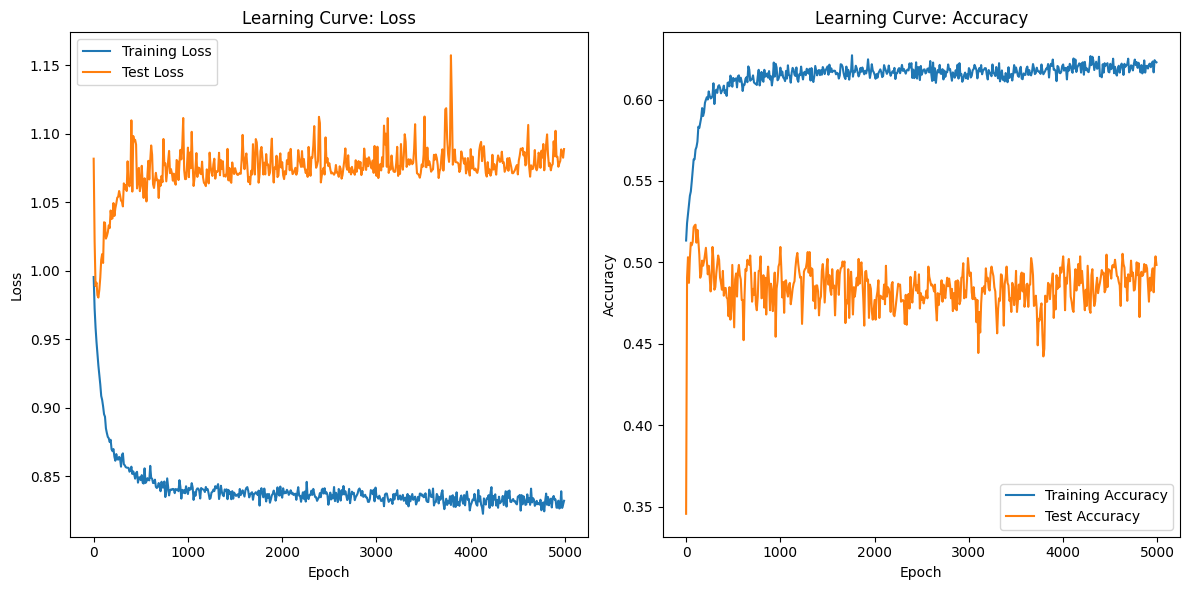

In [3]:
# Plotting the learning curve
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(0, epochs, 10), train_losses, label='Training Loss')
plt.plot(range(0, epochs, 10), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curve: Loss')

plt.subplot(1, 2, 2)
plt.plot(range(0, epochs, 10), train_accuracies, label='Training Accuracy')
plt.plot(range(0, epochs, 10), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Learning Curve: Accuracy')

plt.tight_layout()
plt.show()

In [4]:
# Save the entire model
torch.save(model, 'model_baseline.pth')

# Save the preprocessing pipeline
joblib.dump(pipeline, 'preprocessing_pipeline_baseline.pkl')

['preprocessing_pipeline_baseline.pkl']